In [32]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier

import time 
import sys
import os
from collections import Counter
import pickle as pkl
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def load_dataset(filename):
    dataset = pd.read_csv(filename,index_col = "TR_NO",usecols = ["TR_NO","TR_AMT","TR_BAL_AMT","FUND_USE","IS_CASH"])
    dataset = dataset.replace([np.inf, -np.inf], np.nan).fillna(value=0)
    return dataset

def get_negtive_trans(filename):
    return set(pd.read_csv(filename)["TR_NO"].values)

In [3]:
training_dataset_filename = "T3H_TRANS_ALL_WW_DATA_TABLE.csv"
case_filename = "T3H_TRANS_YSB_WW_DATA_TABLE.csv"

## ------- load dataset --------
if not os.path.exists("unsup_cases.pkl") or not os.path.exists("unsup_training_dataset.pkl"):
    training_dataset = load_dataset(training_dataset_filename)
    cases = get_negtive_trans(case_filename)

    with open("unsup_cases.pkl","wb") as f:
        pkl.dump(cases,f)
    with open("unsup_training_dataset.pkl","wb") as f:
        pkl.dump(training_dataset,f)
else:
    with open("unsup_cases.pkl","rb") as f:
        cases = pkl.load(f)
    with open("unsup_training_dataset.pkl","rb") as f:
        training_dataset = pkl.load(f)

## Feature engneering

In [4]:
encoder = LabelEncoder()
training_dataset["FUND_USE"] = encoder.fit_transform(training_dataset["FUND_USE"].astype(str))
training_dataset.head()

,IS_CASH,TR_AMT,TR_BAL_AMT,FUND_USE
TR_NO,,,,
0013840100000026,1,61260.0,111260.0,974
0013840100000027,1,110000.0,1260.0,783
0013840100000027,1,110000.0,110000.0,783
0013840100000028,0,10000.0,0.0,973
0013840100000029,0,12000.0,12000.0,737


## 查看每个TR_NO交易个数

In [5]:
print(training_dataset.groupby("TR_NO").size().head())
print("")
print(training_dataset.loc[cases].groupby("TR_NO").size().head())
print("")
print(training_dataset.loc[cases].groupby("TR_NO").size().describe())

TR_NO
00000000000020180814000300014016    1
00000000000020180814000300014021    1
00000000000020180814000300014026    1
00000000000020180814000300014032    1
00000000000020180814000300014038    1
dtype: int64

TR_NO
ED00010101000001    30
ED00010101000011    23
ED00010101000040    24
ED00010101000110    21
ED00010101000126    15
dtype: int64

count    4698.000000
mean       24.579821
std        10.213524
min         1.000000
25%        18.000000
50%        31.000000
75%        32.000000
max        55.000000
dtype: float64


## create NUM_TRANS

In [6]:
table = training_dataset.groupby("TR_NO").size().to_dict()
values = training_dataset.index.to_series().map(table)
training_dataset["NUM_TRANS"] = values

In [7]:
abnormal_transactions = training_dataset.loc[cases]

## IS_CASH

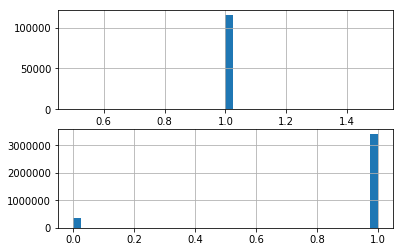

In [8]:
%matplotlib inline
plt.subplot(2, 1, 1)
abnormal_transactions["IS_CASH"].hist(bins = 40)
plt.subplot(2,1,2)
training_dataset["IS_CASH"].hist(bins = 40)

## FUND_USE

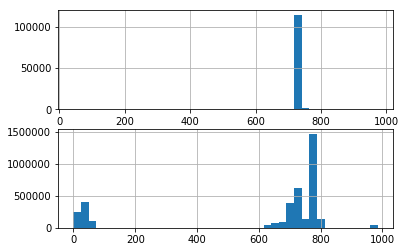

In [16]:
%matplotlib inline
plt.subplot(2, 1, 1)
abnormal_transactions["FUND_USE"].hist(bins = 40)
plt.subplot(2,1,2)
training_dataset["FUND_USE"].hist(bins = 40)

## NUM_TRANS

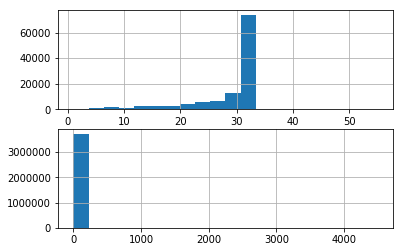

In [17]:
%matplotlib inline
plt.subplot(2, 1, 1)
abnormal_transactions["NUM_TRANS"].hist(bins = 20)
plt.subplot(2,1,2)
training_dataset["NUM_TRANS"].hist(bins = 20)

In [35]:
def creat_labels(training_dataset,cases):
    training_dataset["Y"] = 1
    training_dataset.loc[training_dataset.index.isin(cases),"Y"] = 0
    labels = training_dataset["Y"].values
    training_dataset.drop(labels = "Y",axis = 1,inplace = True)
    return labels
labels = creat_labels(training_dataset,cases)    

In [36]:
print("samples distribution: {}".format(Counter(labels)))

samples distribution: Counter({1: 3648850, 0: 115476})


In [42]:
scaler = StandardScaler()
training_dataset = scaler.fit_transform(training_dataset)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(training_dataset,labels,test_size=0.3, random_state=42)

clf = XGBClassifier(scale_pos_weight = Counter(labels)[0] / Counter(labels)[1])
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.03164723131945681,
       seed=None, silent=True, subsample=1)

In [48]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.98      0.39     34564
           1       1.00      0.91      0.95   1094734

   micro avg       0.91      0.91      0.91   1129298
   macro avg       0.62      0.94      0.67   1129298
weighted avg       0.98      0.91      0.93   1129298

